# A guide to consuming the Flood Predictor service

In [17]:
import os, requests, json
import numpy as np
import matplotlib.pyplot as plt

### How to POST a valid request

To use Flood Predictor, you will be provided with a scoring URI

In [2]:
scoring_uri = 'http://1af16b6b-db6e-4679-82d9-ef3aac127cb7.eastus.azurecontainer.io/score'

The swagger json can be consumed using the GET method to obtain relevant information such as what input the scoring service expects

In [3]:
swagger_uri = 'http://1af16b6b-db6e-4679-82d9-ef3aac127cb7.eastus.azurecontainer.io/swagger.json'

The json we POST to /score needs to have the following elements

In [4]:
swagger_response = requests.get(swagger_uri)
print(json.dumps(swagger_response.json()['definitions']['ServiceInput']['properties']['Inputs']['required'], indent=2))

[
  "runoff",
  "huc",
  "row",
  "column"
]


Let's define input data set POST to Flood Predictor

In [5]:
input_data = json.dumps({"Inputs":{'runoff':4.1, 'huc': '071200040505', 'row': 11, 'column': 8}})

In [6]:
# Set the content type
headers = {'Content-Type': 'application/json'}

response = requests.post(scoring_uri, input_data, headers=headers)

Flood predictor returns 1D arrays of probabilities and predictions as well as the dimensions of the downloaded tile. The dimensions allow reshaping the 1D array into 2D arrays for visualization and mapping. While most tiles have 256x256 grid points, some edge tiles might have a smaller number of data in them.

In [7]:
response_json = json.loads(response.text)
response_json.keys()

dict_keys(['dims', 'prediction', 'probability'])

The request response returns a dictionary containing both predictions and probabilities of flooding per pixel for the given runoff. Now we can reshape the probability array into a matrix for visualization.

In [12]:
nrows, ncols = response_json['dims']
print('This tile has',nrows,'rows and',ncols,'columns.')

This tile has 256 rows and 256 columns.


Now, let's reshape the probabilit list.

In [15]:
probability_array_1d = np.array(response_json['probability'], dtype=np.float64)
probability_array_2d = probability_array_1d.reshape(nrows,ncols)

Visualize

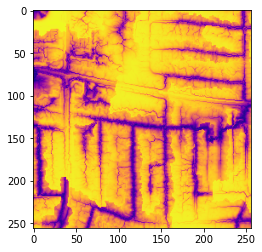

In [18]:
plt.imshow(probability_array_2d, cmap = 'plasma_r')
plt.show()

### How to get a list of HUC options?

Simply, in your input data, pass an empty string for the 'huc' key

In [19]:
input_data = json.dumps({"Inputs":{'runoff':4.1, 'huc': '', 'row': 11, 'column': 8}})

In [20]:
# Set the content type
headers = {'Content-Type': 'application/json'}

response = requests.post(scoring_uri, input_data, headers=headers)

List 4 choices

In [21]:
response_json = json.loads(response.text)
response_json['huc_choices'][:4]

['043001081505', '043001081507', '043001060504', '020301030906']

In [25]:
print('In total there are',len(response_json['huc_choices']),'HUC choices.')

In total there are 30 HUC choices.


### For a given HUC, get a list of available rows, the range of latitudes for the whole HUC, the number of grid points in that direction, and a coordinate reference system

Pass a negative row number

In [26]:
input_data = json.dumps({"Inputs":{'runoff':4.1, 'huc': '043001060504', 'row': -1, 'column': 8}})

In [27]:
# Set the content type
headers = {'Content-Type': 'application/json'}

response = requests.post(scoring_uri, input_data, headers=headers)

In [29]:
response_json = json.loads(response.text)
response_json.keys()

dict_keys(['crs', 'lat_dim', 'lat_range', 'row_choices'])

Get a sample of available rows

In [31]:
response_json['row_choices'][:4]

[0, 1, 2, 3]

What is the latitude extent of the HUC?

In [32]:
response_json['lat_range']

[5565995.0, 5593040.0]

In what coordinate reference system (CRS) does the previous result lie?

In [33]:
response_json['crs']

'EPSG:3857'

What is the number of grid points or pixels along the latitudes?

In [35]:
response_json['lat_dim']

9015

In [37]:
print('Even though there are', len(response_json['row_choices']),'rows, there are only', response_json['lat_dim'],
      'pixels along the latitudes. This is on average', response_json['lat_dim']/len(response_json['row_choices']),
      'pixels per tile. This is less than 256 because edge tiles may have less pixels than the rest.')

Even though there are 36 rows, there are only 9015 pixels along the latitudes. This is on average 250.41666666666666 pixels per tile. This is less than 256 because edge tiles may have less pixels than the rest.


### For a given HUC and row, get a list of available columns, the range of longitudes for the whole HUC, and the number of grid points in that direction

Pass a negative column number

In [38]:
input_data = json.dumps({"Inputs":{'runoff':4.1, 'huc': '020301030906', 'row': 0, 'column': -1}})

In [39]:
# Set the content type
headers = {'Content-Type': 'application/json'}

response = requests.post(scoring_uri, input_data, headers=headers)

In [40]:
response_json = json.loads(response.text)
response_json.keys()

dict_keys(['column_choices', 'crs', 'long_dim', 'long_range'])

By accessing the information here like in the previous section, one is able to locate tiles on a map and plot the whole HUC's probability array on a map.